In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd

In [2]:
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

In [3]:
from scipy.signal import find_peaks
import scipy

In [4]:
from scipy import signal

In [5]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

In [30]:
df = pd.read_csv('data/sample.csv', names=['X','Y','Z'])
sr=100
df['Time'] = [s/sr for s in range(0,df.shape[0])]

In [31]:
df.head()

,X,Y,Z,Time
0,0.123301,-0.023942,9.731233,0.00
1,0.123301,-0.023942,9.731233,0.01
2,0.123301,-0.023942,9.731233,0.02
3,0.123301,-0.023942,9.731233,0.03
4,0.123301,-0.023942,9.731233,0.04


Approximate breathing cylces =  37


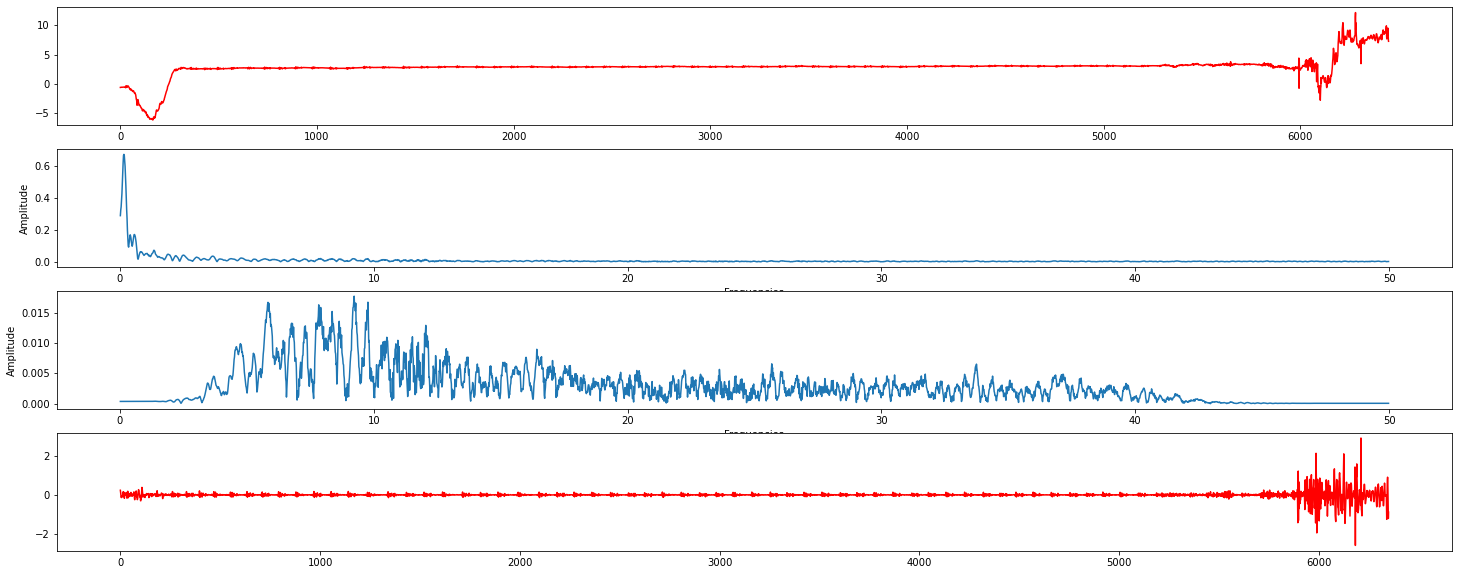

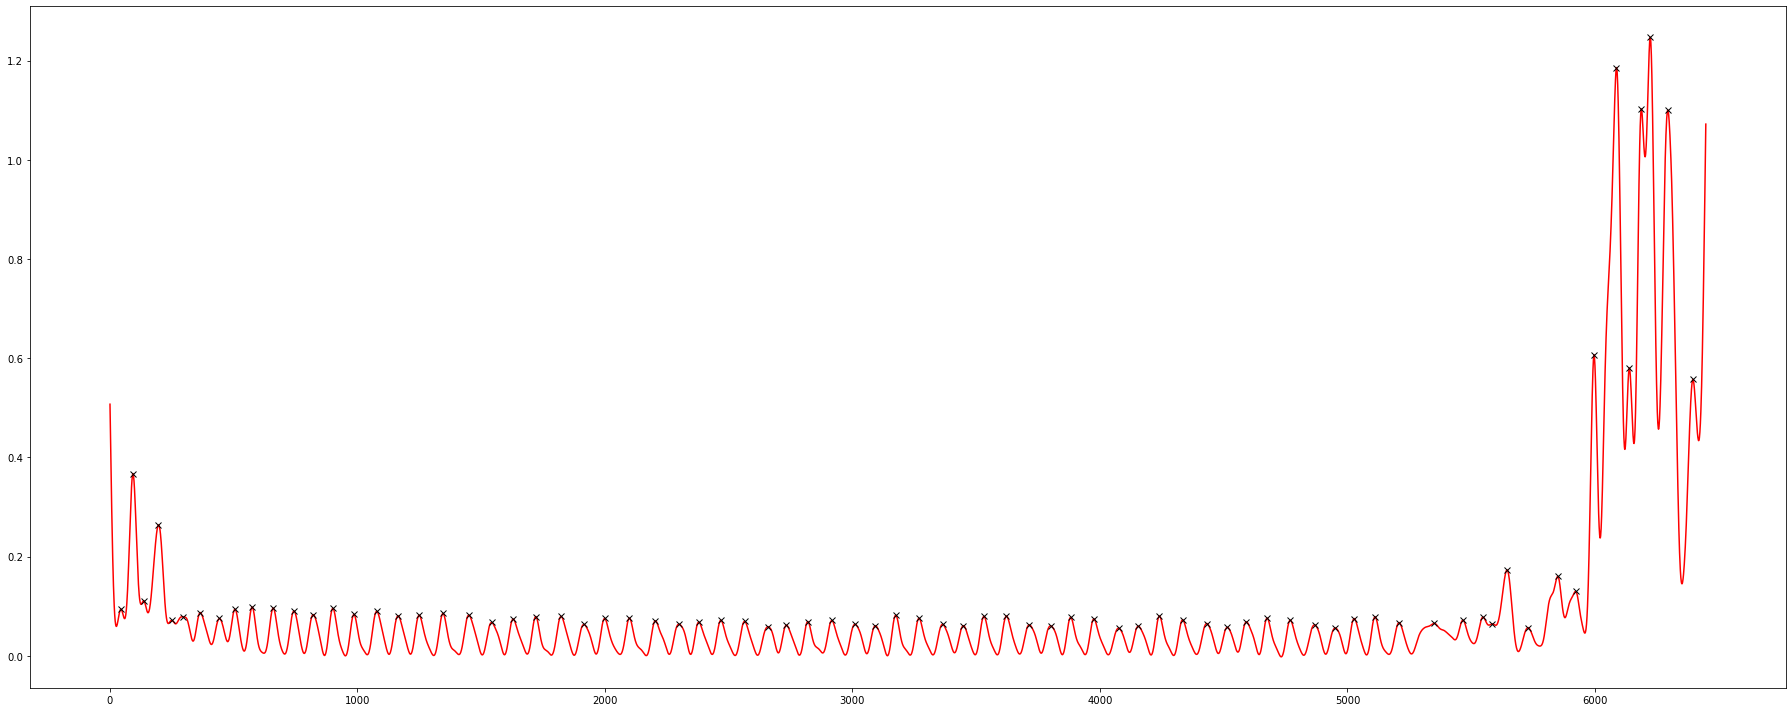

In [103]:
df = pd.read_csv('data/sensorlog_20210721_155550_Nipun.csv')
df.index = df.Timestamp
df = df.drop(['Timestamp'], axis=1)
df.index = pd.to_datetime(df.index)

#filter using convolution
size = 2
window = np.ones(size)/size
#window = scipy.signal.gaussian(M=size, std=6)
window /= window.sum()
#filtered = np.convolve(df['Z'], window, mode='valid')


fig, ax = plt.subplots(4,1,figsize=(25,10))
#peaks,_ = find_peaks(filtered)
ax[0].plot(range(0, (len(df.index))), df['Z'], color='red');

FS, HS = compute_fft(df['Z'], 100, scale_amplitudes=True)
ax[1].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
ax[1].set_xlabel('Frequencies')
ax[1].set_ylabel('Amplitude');

cutoff_low = 5 
cutoff_high = 40
order = 5
sr = 100
filteredHP = butter_bandpass_filter(df['Z'],cutoff_low,cutoff_high,sr,order)

FS, HS = compute_fft(filteredHP, 100, scale_amplitudes=True)
ax[2].plot(FS[1:], HS[1:]) #starts from 1 to avoid plotting DC component
ax[2].set_xlabel('Frequencies')
ax[2].set_ylabel('Amplitude');
ax[3].plot(range(0, (len(df.index)-100)), filteredHP[100:], color='red');

#apply hilbert transform
fig, ax = plt.subplots(1,1, figsize=(25,10))
fs = 100
x_filt_hilbert = signal.hilbert(filteredHP)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)

#find peaks
peaks,_ = find_peaks(envelope_hat_filt)

#ax.plot([s/fs for s in range(0,len(filteredHP))],envelope_hat_filt,'r')
ax.plot(range(0,len(filteredHP)),envelope_hat_filt,'r')
ax.plot(peaks, [envelope_hat_filt[i] for i in peaks], "x", color='black')
print("Approximate breathing cylces = ",(len(peaks)-2)//2)
fig.tight_layout();

